# Fit a binary model to your event from Day 4 class

Here we will show you how to fit a binary model to your planetary event.

## Load packages

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize

import MulensModel as mm

%matplotlib widget

## Set up a bunch of important functions

We need to set up a bunch of important functions here. They come from [**Example 8 for MulensModel**](https://github.com/rpoleski/MulensModel/blob/master/examples/example_08_planet_grid_fitting.ipynb).

In [15]:
def chi2_fun(theta, event, parameters_to_fit):
    """                                                                         
    Chi2 function. Changes values of the parameters and recalculates chi2.
    
    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2()

## Load data

In [5]:
# There should be a "randomized" microlensing event here
# to make it simple I will load an old event from SAGAN workshop
data = np.loadtxt('data/WFIRST_binary_SAGAN.dat')

## Set up a model and an event

In [8]:
roman_data = mm.MulensData(data_list = data.T, 
                                   plot_properties={'color':'purple', 'label':'Roman', 'marker':'x', 'markersize':2}, 
                                   phot_fmt='mag', 
                                   bandpass='F149')

Text(0, 0.5, 'F149 [mag]')

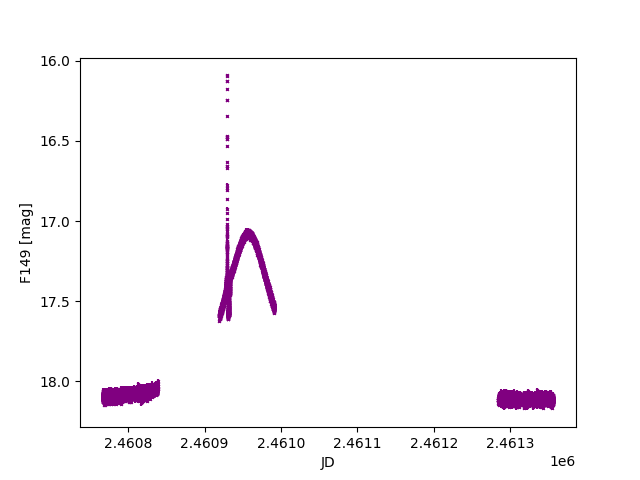

In [14]:
## Lets have a look at the data
fig = plt.figure()
roman_data.plot()
plt.xlabel('JD')
plt.ylabel('F149 [mag]')

Define the period when your planetary event is happening.

In [19]:
# ***Set time range of planetary perturbation (including 2460000).***
# Use the plot above to find when your event is happening.
(t_planet_start, t_planet_stop) = (246080., 2461085.)

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    0., 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2470000.]

Now, set up the event using the parameters you found using analytical equations earlier.

In [25]:
# Now we define model using the parameters you found earlier
t0, u0, tE = 2457792., 0.3, 10 # put your parameters here
rho, s, q = 0., 0., 0.
alpha = 0.

Theta0 = np.array([t0, u0, tE, rho, s, q, alpha])  # initial guess
labels = np.array(['t_0', 'u_0', 't_E', 'rho', 's', 'q', 'alpha']) # parameter labels

# Define the Point Lens Model
point_lens_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
point_lens_event = mm.Event(datasets=roman_data, model=point_lens_model)
print('Initial Guess')
print(point_lens_model)

Initial Guess
    t_0 (HJD)       u_0    t_E (d) 
2457792.00000  0.300000    10.0000 
default magnification method: point_source


Let's have a look at the model.

IndexError: list index out of range

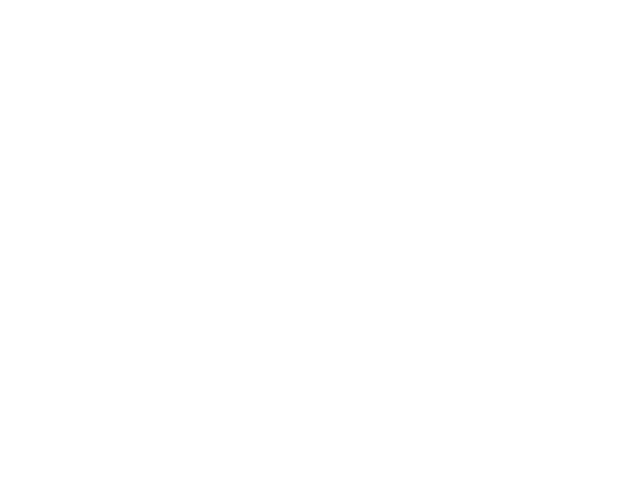

In [28]:
fig = plt.figure()
point_lens_event.plot_model(color='black', zorder=10)
point_lens_event.plot_data()
plt.show()
print(point_lens_event.get_ref_fluxes())
print(point_lens_event.model.get_magnification(t_0))

In [13]:

config.read(config_file)
files = read.read_files_from_config(config)
model_settings = read.read_model_settings(config)
(parameters, starting) = read.read_parameters_start(config)
fixed_parameters = read.read_fix_parameters(config)
(min_values, max_values) = read.read_min_max(config)
ln_prior.min = min_values
ln_prior.max = max_values
emcee_settings = read.read_emcee_settings(config)
other_settings = read.read_other(config)

# Read photometric data.
datasets = [mm.MulensData(file_name=f[0], phot_fmt=f[1]) for f in files]

# Generate starting values of parameters.
start = generate_random_parameters(parameters, starting,
                                   emcee_settings['n_walkers'])

# Setup Event instance that combines model and data.
par = dict(zip(parameters, start[0]))
par = {**par, **fixed_parameters}
my_model = mm.Model(par, coords=model_settings['coords'])
if 'methods' in model_settings:
    my_model.set_magnification_methods(model_settings['methods'])
if 'default_method' in model_settings:
    my_model.default_magnification_method = model_settings['default_method']
my_event = mm.Event(datasets=datasets, model=my_model)

# Prepare sampler.
n_dim = len(parameters)
print_models = other_settings.get('print_models', False)
args = (my_event, parameters, print_models)
sampler = emcee.EnsembleSampler(emcee_settings['n_walkers'], n_dim, ln_prob,
                                args=args)

# Run sampler.
sampler.run_mcmc(start, emcee_settings['n_steps'])

# Parse results.
burn = emcee_settings['n_burn']
samples = sampler.chain[:, burn:, :].reshape((-1, n_dim))
r_16 = np.percentile(samples, 16, axis=0)
r_50 = np.percentile(samples, 50, axis=0)
r_84 = np.percentile(samples, 84, axis=0)
print("Fitted parameters:")
for i in range(n_dim):
    if parameters[i] == 'q':
        fmt = "{:} {:.7f} +{:.7f} -{:.7f}"
    else:
        fmt = "{:} {:.5f} +{:.5f} -{:.5f}"
    print(fmt.format(parameters[i], r_50[i], r_84[i]-r_50[i], r_50[i]-r_16[i]))

# We extract best model parameters and chi2 from the chain:
prob = sampler.lnprobability[:, burn:].reshape((-1))
best_index = np.argmax(prob)
best_chi2 = prob[best_index] / -0.5
best = samples[best_index, :]
print("\nSmallest chi2 model:")
print(*[repr(b) if isinstance(b, float) else b.value for b in best])
print(best_chi2)
for (parameter, best_) in zip(parameters, best):
    setattr(my_event.model.parameters, parameter, best_)

my_event.fit_fluxes()

# Plot results.
ln_like(best, my_event, parameters, False)  # This allows plotting of
# the best model.
print(my_event.model)
my_event.plot_data(subtract_2450000=True)
my_event.plot_model(
    subtract_2450000=True,
    t_start=other_settings['plot_time'][0]+2450000.,
    t_stop=other_settings['plot_time'][1]+2450000.)
plt.xlim(*other_settings['plot_time'])
plt.show()

NameError: name 'config' is not defined